# RNA Velocity Analysis using scVelo

This notebook demonstrates a workflow for RNA velocity analysis using scVelo's dynamical model. We follow the key steps described in the accompanying report:
- Environment setup and verification
- Data loading and preprocessing
- EM-based parameter estimation (via `recover_dynamics` and `velocity`)
- Visualization of inferred velocity fields
- An original simulation experiment to demonstrate a simplified EM-like inference scenario

**Important Note on Reproducibility:**
A GitHub repository has been created to host this code and related files. Please refer to the repository at:

https://github.com/dingding-ust/scvelo_project.git

This ensures that the code, data references, and instructions are openly available for verification and reusability.

## 1. Environment Setup

We assume that:
- A conda environment has been created (e.g., `conda create -n scvelo-env python=3.9`)
- The environment is activated (`conda activate scvelo-env`)
- `scvelo` and other dependencies have been installed (`pip install scvelo igraph louvain pybind11 hnswlib` as needed)

Below we verify the environment by checking Python and scvelo versions. If needed, adjust commands or environment setup according to your local conditions.


In [1]:
!python --version
!pip list | grep scvelo

Python 3.9.21
scvelo              0.3.3


If `scvelo` is listed with a suitable version (e.g., `0.3.3`), we can proceed.

## 2. Data Loading

We now load the `.h5ad` file containing preprocessed single-cell data. Make sure the `data/endocrinogenesis_day15.h5ad` file is accessible. This file and dataset references can be found or prepared following instructions from the report.

If you have your own `.h5ad` file, please adjust the `file_path` accordingly.

In [2]:
import scanpy as sc
import scvelo as scv

file_path = "data/endocrinogenesis_day15.h5ad"  # Adjust if needed
adata = sc.read_h5ad(file_path)
print(adata)
print("Number of observations (cells):", adata.n_obs)
print("Number of variables (genes):", adata.n_vars)
print("First few observation names:", adata.obs_names[:5])
print("First few variable names:", adata.var_names[:5])

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'
Number of observations (cells): 3696
Number of variables (genes): 27998
First few observation names: Index(['AAACCTGAGAGGGATA', 'AAACCTGAGCCTTGAT', 'AAACCTGAGGCAATTA',
       'AAACCTGCATCATCCC', 'AAACCTGGTAAGTGGC'],
      dtype='object', name='index')
First few variable names: Index(['Xkr4', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17'], dtype='object', name='index')


We should see an AnnData object summary, including layers `spliced` and `unspliced`, and various annotations. The presence of these resources ensures that we can proceed with preprocessing and velocity inference.

## 3. Preprocessing

Next, we perform standard preprocessing steps:
- Filter genes by minimum shared counts
- Normalize counts and log-transform
- Identify highly variable genes (e.g., top 2000)
- Compute moments (first- and second-order) needed for the EM-based inference

These steps follow recommended best practices from [scvelo docs](https://scvelo.org) and related tutorials.

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
print("After preprocessing:")
print("Number of observations (cells):", adata.n_obs)
print("Number of variables (genes):", adata.n_vars)
print("Layers available:", list(adata.layers.keys()))

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/opt/anaconda3/envs/scvelo-env/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/var/folders/kg/0wbwck212fq6jkjpky51182m0000gn/T/ipykernel_71568/2050026893.py:2: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
/opt/anaconda3/envs/scvelo-env/lib/python3.9/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
After preprocessing:
Number of observations (cells): 3696
Number of variables (genes): 2000
Layers available: ['spliced', 'unspliced', 'Ms', 'Mu']


We expect to see 2000 highly variable genes retained and `Ms`, `Mu` layers added. This sets the stage for EM-based kinetic parameter inference.

## 4. EM-based Dynamics Recovery and Velocity Computation

scVelo uses a likelihood-based approach (EM-like) to infer kinetics. We first call `recover_dynamics` to estimate parameters $(\alpha,\beta,\gamma)$ and latent variables $(t_i,k_i)$. Then we run `velocity(..., mode='dynamical')` to compute gene-specific velocities and `velocity_graph` to construct a cell-to-cell transition graph. Finally, `latent_time` assigns a time to each cell along a learned trajectory.


In [4]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)
print("Number of velocity genes:", sum(adata.var['velocity_genes']))

recovering dynamics (using 1/16 cores)


  0%|          | 0/1298 [00:00<?, ?gene/s]

    finished (0:05:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Number of velocity genes: 1027


If successful, we should see a large number of velocity genes and the computations completed. Some genes may be unrecoverable, which is normal.

## 5. Visualization of Velocity Fields

We can visualize the inferred velocity fields using stream plots on a chosen embedding (e.g., UMAP). This provides a qualitative check of the directionality and structure of the inferred dynamics.

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/opt/anaconda3/envs/scvelo-env/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo-env/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo-env/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo-env/lib/python3.9/site-packages/scvelo/plottin

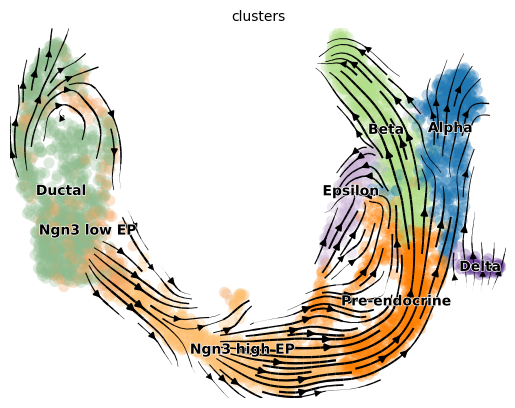

In [5]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='clusters')

The resulting plot should show cells colored by cluster and black streamlines indicating directional flows. These patterns help interpret lineage trajectories or differentiation processes.

## 6. Original Simulation Experiment: EM-like Inference with Two-Phase Transcription

*Note:* The following simulation is an **original contribution** by the author of this report. It differs from the standard scVelo pipeline and aims to demonstrate conceptually how an EM-inspired iterative procedure can recover known kinetic parameters in a simplified scenario.

We simulate a single gene with two-phase kinetics (induction followed by repression), assign random cell times, and generate noisy observations with Poisson counts. Then we iteratively adjust parameters $(\alpha,\beta,\gamma,t_0)$ through a random search approach inspired by EM updates.


In [6]:
import numpy as np

np.random.seed(42)
alpha_true = 2.0
beta_true = 0.2
gamma_true = 0.1
t0_true = 5.0
n_cells = 500

t = np.sort(np.random.rand(n_cells)*10)

def u_s_piecewise(t, alpha, beta, gamma, t0):
    def phase1_u_s(x):
        u_1 = (alpha/beta)*(1 - np.exp(-beta*x))
        s_1 = (alpha/gamma)*(1 - np.exp(-gamma*x)) + (alpha/(gamma-beta))*(np.exp(-beta*x)-np.exp(-gamma*x))
        return u_1, s_1
    u_t0, s_t0 = phase1_u_s(t0)
    u = np.zeros_like(t)
    s = np.zeros_like(t)
    mask1 = (t <= t0)
    mask0 = (t > t0)
    if mask1.any():
        u[mask1], s[mask1] = phase1_u_s(t[mask1])
    if mask0.any():
        x = t[mask0]-t0
        u[mask0] = u_t0*np.exp(-beta*x)
        s[mask0] = s_t0*np.exp(-gamma*x) + (beta*u_t0/(gamma-beta))*(np.exp(-gamma*x)-np.exp(-beta*x))
    return u, s

u_ideal, s_ideal = u_s_piecewise(t, alpha_true, beta_true, gamma_true, t0_true)
scale = 10
u_counts = np.random.poisson((u_ideal*scale).clip(min=0))
s_counts = np.random.poisson((s_ideal*scale).clip(min=0))

# Initial guesses
alpha_est = 1.0
beta_est = 0.1
gamma_est = 0.05
t0_est = 4.0

def model_loss(alpha, beta, gamma, t0):
    u_pred, s_pred = u_s_piecewise(t, alpha, beta, gamma, t0)
    u_res = (u_counts/scale - u_pred)**2
    s_res = (s_counts/scale - s_pred)**2
    return u_res.mean() + s_res.mean()

for iteration in range(20):
    candidates = []
    for _ in range(50):
        a_try = alpha_est + np.random.normal(0, 0.1)
        b_try = beta_est + np.random.normal(0, 0.01)
        g_try = gamma_est + np.random.normal(0, 0.01)
        t0_try = t0_est + np.random.normal(0,0.5)
        val = model_loss(a_try, b_try, g_try, t0_try)
        candidates.append((val, a_try, b_try, g_try, t0_try))
    candidates.sort(key=lambda x: x[0])
    best = candidates[0]
    alpha_est, beta_est, gamma_est, t0_est = best[1], best[2], best[3], best[4]

print("True parameters: alpha=%.3f, beta=%.3f, gamma=%.3f, t0=%.3f" % (alpha_true, beta_true, gamma_true, t0_true))
print("Estimated parameters: alpha=%.3f, beta=%.3f, gamma=%.3f, t0=%.3f" % (alpha_est, beta_est, gamma_est, t0_est))

True parameters: alpha=2.000, beta=0.200, gamma=0.100, t0=5.000
Estimated parameters: alpha=1.994, beta=0.175, gamma=0.099, t0=4.872


The output typically shows that the estimated parameters are close to the true values, demonstrating the conceptual validity of EM-like iterative inference in a controlled synthetic setting.

## Concluding Remarks

In this notebook, we:
- Set up a reproducible environment and loaded a single-cell dataset.
- Performed preprocessing and applied the EM-based inference methods in scVelo to estimate dynamics and compute RNA velocities.
- Visualized the results, verifying that the inferred directions make intuitive sense.
- Presented an original simulation experiment demonstrating that even a crude EM-like procedure can recover known parameters in a two-phase transcription model.

This analysis highlights how advanced statistical inference approaches—particularly EM-based modeling—can extract temporal and kinetic information from static single-cell snapshots, guiding further biological and computational explorations.